<a href="https://colab.research.google.com/github/tyleryou/housing_data/blob/main/housing_data_transform_roughdraft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## I think I need to use onehotencoder instead of dummy variables, and need to scale y somehow. And concating pandas dataframes is just making up 0's and doesn't work. Can I concat without throwing in NaN values? Try adding ID to categorical features and joining on that. Also, try dropping the NaN instances. -- Dropping null values did improve the model, but I had to drop y values as well. Only had to drop 8, so might be worth just dropping instead of filling with the mean.
## Null values come from concatenating in general. Can I standardize and impute sans separating the data?
## trainset_total.reset_index(drop=True, inplace=True) fixed the concat issue, and completely validated the model and basically fixed everything.
## Now to make OneHotEncoder work and stack the models.

In [ ]:
import sklearn
import numpy as np                 # Linear Algebra Calculations
import matplotlib.pyplot as plt    # Data Plotting
import pandas as pd                # DataFrames
pd.options.mode.chained_assignment = None  # default='warn', turn off warning errors when writing pandas dataframes over original dataframe.
import seaborn as sns              # Data Visualization
sns.set_theme(style='darkgrid')

In [ ]:
## Importing the data from github repository.

url = 'https://raw.githubusercontent.com/tyleryou/housing_data/main/ingested_train.csv'

trainingset = pd.read_csv(url)

url_test = 'https://raw.githubusercontent.com/tyleryou/housing_data/main/ingested_test.csv'

testset = pd.read_csv(url_test)

Now that the features have been thinned, we can look into feature transformation.

First among the transformation work is filling in the missing data. However, to do this we must check for outliers in the data so that we can use means or medians that accurately represent each feature.

First up on the list of features is the highest correlated one, OverallQual. Graphically we can see this as a bar graph.

In [ ]:
pivot = trainingset.pivot_table(index='OverallQual', values='SalePrice')

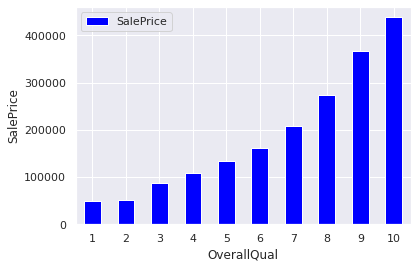

In [ ]:
pivot.plot(kind='bar', color='blue')
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.xticks(rotation=0)
plt.show()

Here we can see that as OverallQual gets a higher magnitude, so does the SalePrice. This makes sense, and does not show any outliers that stand out.

Next we'll look into TotalSqFt, which is the second highest correlated feature to the target. 

In [ ]:
## Defining a function to plot a correlation scatter plot between a feature and the target.
def PltSctter(feature):
  plt.scatter(x=trainingset[feature], y=trainingset['SalePrice'])
  plt.xlabel(feature)
  plt.ylabel('SalePrice')
  plt.show()

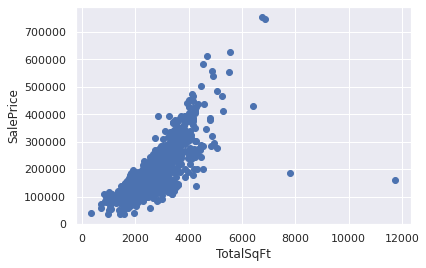

In [ ]:
PltSctter('TotalSqFt')

Here we can see there are a couple of outliers to the data. These could throw off linear regression models, of which the predictions will likely be based on. It's a good idea to remove these.

In [ ]:
trainingset = trainingset[trainingset['TotalSqFt'] < 7000]

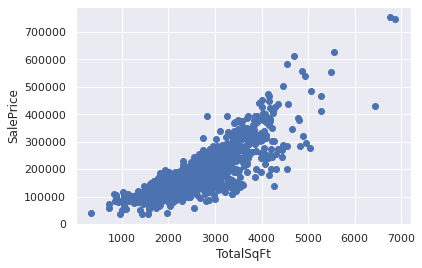

In [ ]:
PltSctter('TotalSqFt')

While this data still isn't very linear, it is much better in terms of outliers.

Next is visualizing the correlation between GrLivArea and the target SalePrice.

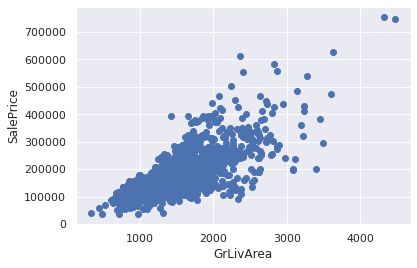

In [ ]:
PltSctter('GrLivArea')

No outliers here, but we can see a conic shape to the data which represents heteroscedascticity. The linear regression models will predict more efficiently when data shows homoscedascticity -- which is an even linear distribution of the data values. This can be achieved through further transformation, which is what we will do later.

Next up is to look at GarageCars.

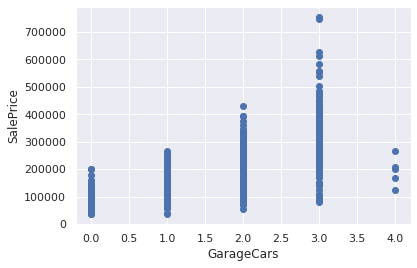

In [ ]:
PltSctter('GarageCars')

Interestingly we can see that houses that have four car garages are worth less. Since all of the 4 car garages are worth less, we can assume these aren't outliers and is a good representation of the GarageCars worth.

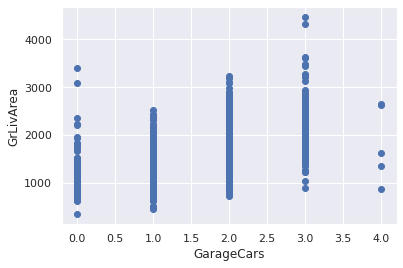

In [ ]:
plt.scatter(x=trainingset['GarageCars'], y=trainingset['GrLivArea'])
plt.ylabel('GrLivArea')
plt.xlabel('GarageCars')
plt.show()

Looks like the GrLivArea decreases as GarageCars increases. This appears to be an accuarte representation and makes sense, as a garage this big isn't entirely necessary and may cut into the living area of the home.

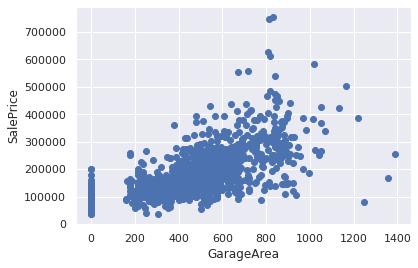

In [ ]:
PltSctter('GarageArea')

Here we can see the graphical representation of 0 values in the data. However, these aren't necessarily missing. The 0's can mean there is no garage, so we don't want to fill these in with median values. A few outliers, but not as pronounced as the ones from TotalSqFt. We'll leave these here, as we don't want to eliminate too much data.

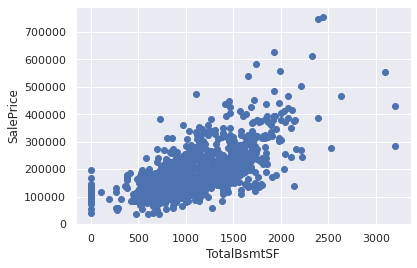

In [ ]:
PltSctter('TotalBsmtSF')

Nothing crazy here, we have some zero values but these could represent a lack of basement.

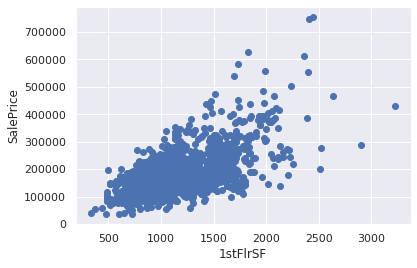

In [ ]:
PltSctter('1stFlrSF')

No issues here.

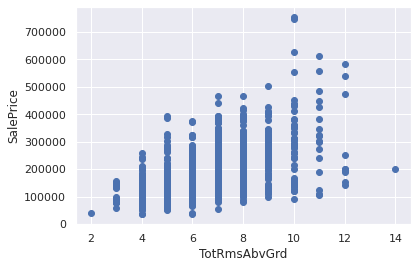

In [ ]:
PltSctter('TotRmsAbvGrd')

Some houses have more rooms but are worth considerably less, this could be due to the quality of the house.

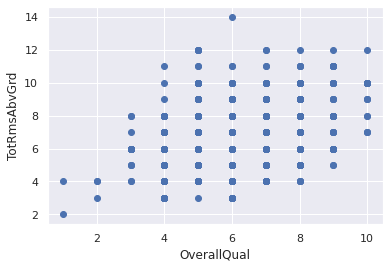

In [ ]:
plt.scatter(x=trainingset['OverallQual'], y=trainingset['TotRmsAbvGrd'])
plt.ylabel('TotRmsAbvGrd')
plt.xlabel('OverallQual')
plt.show()

We can see here that the 14 room home is only rated as 6 for Overall Quality. This means the house is probably very large, but also quite poor quality. Still, this is quite an outlier so we can go ahead and remove it.

In [ ]:
trainingset = trainingset[trainingset['TotRmsAbvGrd'] < 14]

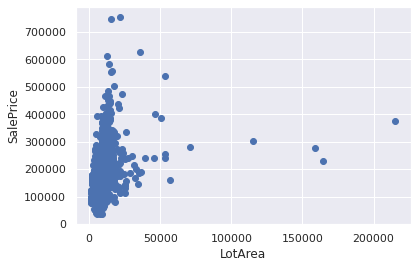

In [ ]:
PltSctter('LotArea')

In [ ]:
trainingset = trainingset[trainingset['LotArea'] < 70000]

Now it's time to fill in missing values for the categorical features. First we have to split the dataset into numerical and categorical features.

In [ ]:
y = trainingset['SalePrice']

In [ ]:
trainingset = trainingset.drop(columns = 'SalePrice')

In [ ]:
trainset_nums = trainingset.select_dtypes(np.number)
trainset_cats = trainingset.select_dtypes([object])

In [ ]:
testset_nums = trainingset.select_dtypes(np.number)
testset_cats = trainingset.select_dtypes([object])

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
filled_nums = imputer.fit_transform(trainset_nums)

In [ ]:
testset_numfilled = imputer.transform(testset_nums)

In [ ]:
filled_nums = pd.DataFrame(filled_nums,columns=trainset_nums.columns)

In [ ]:
testset_numfilled = pd.DataFrame(testset_numfilled,columns=testset_nums.columns)

In [ ]:
#encoded_cats = pd.get_dummies(trainset_cats, drop_first = True) ## Commenting out to include OHC.

In [ ]:
#encoded_testcats = pd.get_dummies(testset_cats, drop_first = True)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohc = OneHotEncoder(drop='first', sparse=False) ## Dropping one of the categories per feature to avoid dummy variable trap. Try not dropping to see what happens.

In [ ]:
encoded_cats = pd.DataFrame(ohc.fit_transform(trainset_cats))

In [ ]:
encoded_testcats = pd.DataFrame(ohc.transform(testset_cats))

In [ ]:
y = np.log1p(y)

In [ ]:
#a = trainingset.iloc[:,2]

In [ ]:
#i = 0
#for i in trainingset.iloc[1,i]:
#  if trainingset.iloc[1,i].dtype == 'O':
#    print('test')

In [ ]:
#from sklearn.preprocessing import Normalizer
#norm = Normalizer()
#filled_nums = pd.DataFrame(norm.fit_transform(filled_nums,y),columns=trainset_nums.columns) #### I think Y needs to be scaled somehow. What's happening in this normalizer? What is it doing with y?

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() # No parameters needed
filled_nums = pd.DataFrame(sc.fit_transform(filled_nums, y), columns = trainset_nums.columns) ##### MADE CHANGE HERE
testset_numfilled = pd.DataFrame(sc.transform(testset_numfilled)) 

In [ ]:
#testset_numfilled = pd.DataFrame(norm.transform(testset_numfilled),columns=testset_nums.columns)

In [ ]:
filled_nums.reset_index(drop=True, inplace=True) ## Prepping training data for concat
encoded_cats.reset_index(drop=True, inplace=True)

In [ ]:
testset_numfilled.reset_index(drop=True, inplace=True)
encoded_testcats.reset_index(drop=True, inplace=True)

In [ ]:
trainset_total = pd.concat([filled_nums,encoded_cats],axis=1)

In [ ]:
testset_total = pd.concat([testset_numfilled,encoded_testcats],axis=1)

TRANSFORM END HERE

In [ ]:
#trainset_total = trainset_total.dropna() ## Dropping null instances arising from concating the trainset and testset. Improves model.

In [ ]:
#testset_total = testset_total.dropna() ## Dropping null instances.

In [ ]:
#trainset_total = trainset_total.fillna(trainset_total.mean()) #better results, not by much
#trainset_total = trainset_total.fillna(0)

In [ ]:
#testset_total = testset_total.fillna(trainset_total.mean()) #better results, not by much
#testset_total = testset_total.fillna(0)

In [ ]:
#from sklearn.preprocessing import OneHotEncoder
#ohc = OneHotEncoder(drop='first') ## Dropping one of the categories per feature to avoid dummy variable trap. Try not dropping to see what happens.

In [ ]:
#encoded_cats = ohc.fit_transform(filled_cats)

In [ ]:
x = range(len(testset_total.index)-len(y)) ## A test if the target has less rows than the training and test set, if it does then drop values.
for n in x:
  testset_total = testset_total.drop(labels = n)
  trainset_total = trainset_total.drop(labels = n)

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(np.array(trainset_total),np.array(y))
lr_prediction = lr.predict(np.array(testset_total))

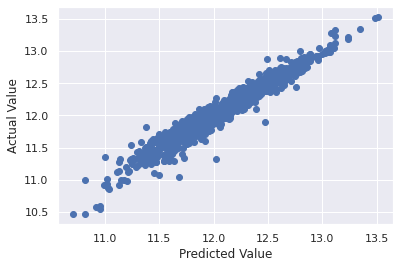

In [ ]:
plt.scatter(x=lr_prediction, y=y)
plt.ylabel('Actual Value')
plt.xlabel('Predicted Value')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [ ]:
def GetErrors(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred) ## Mean Squared Error. Closer to 0 is better.
  rmse = mean_squared_error(y_true, y_pred, squared = False) ## Root Mean Squared Error. Closer to 0 is better.
  mae = mean_absolute_error(y_true, y_pred) ## Mean Absolute Error. Close to 0 is better.
  r2 = r2_score(y_true, y_pred) ## Suppose to be between 0 and 1. Closer to 1 is better. Negative means poorly fitting model.
  print('MSE is: {}'.format(mse))
  print('RMSE is: {}'.format(rmse))
  print('MAE is: {}'.format(mae))
  print('R Squared is: {}'.format(r2))

In [ ]:
GetErrors(y, lr_prediction) ## Figure out why R squared is negative.

MSE is: 0.008909058071718753
RMSE is: 0.09438780679578668
MAE is: 0.0672575775311495
R Squared is: 0.9440265609102738


In [ ]:
from sklearn.svm import SVR
svr_reg = SVR(kernel = 'poly') ## many different kernels, need to look more into this.
svr_reg.fit(np.array(trainset_total), np.array(y))
svr_pred = svr_reg.predict(np.array(testset_total))

In [ ]:
GetErrors(y, svr_pred)

MSE is: 0.005874896889485422
RMSE is: 0.07664787596199533
MAE is: 0.0643107789154827
R Squared is: 0.9630894556355054


In [ ]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=.0003)
clf.fit(np.array(trainset_total), np.array(y))
las_pred = clf.predict(np.array(testset_total))

In [ ]:
GetErrors(y, las_pred)

MSE is: 0.010517866051773211
RMSE is: 0.10255664801354036
MAE is: 0.07250894742516457
R Squared is: 0.9339188127337855


In [ ]:
from sklearn.linear_model import Ridge
ridge_reg = linear_model.Ridge(alpha=.1)
ridge_reg.fit(np.array(trainset_total), np.array(y))
ridge_pred = ridge_reg.predict(np.array(testset_total))

In [ ]:
GetErrors(y, ridge_pred)

MSE is: 0.008961957721874083
RMSE is: 0.09466761707085525
MAE is: 0.06772486743370632
R Squared is: 0.9436942053097153


In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100) ## n_estimators is the amount of trees. Each tree is an estimator
regressor.fit(np.array(trainset_total), np.array(y))
rdmfrst = regressor.predict(np.array(testset_total))

In [ ]:
GetErrors(y, rdmfrst)

MSE is: 0.002789710018061823
RMSE is: 0.05281770553575593
MAE is: 0.036166032931342525
R Squared is: 0.9824729323215807


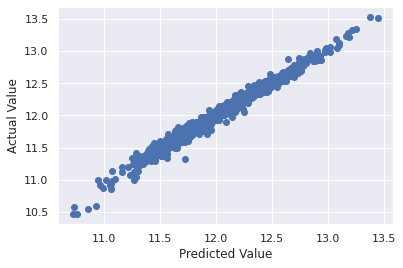

In [ ]:
plt.scatter(x=rdmfrst, y=y)
plt.ylabel('Actual Value')
plt.xlabel('Predicted Value')
plt.show()

In [ ]:
ard_reg = linear_model.ARDRegression()
ard_reg.fit(np.array(trainset_total), np.array(y))
ard_pred = ard_reg.predict(np.array(testset_total))

In [ ]:
GetErrors(y, ard_pred)

MSE is: 0.009977155152025916
RMSE is: 0.09988571044962295
MAE is: 0.07173101314203811
R Squared is: 0.9373159674462721


In [ ]:
from sklearn.ensemble import StackingRegressor

models = [('lr',LinearRegression()),('svr',SVR())]
stacking = StackingRegressor(estimators=models)

In [ ]:
stacking.fit(np.array(trainset_total), np.array(y))

StackingRegressor(estimators=[('lr', LinearRegression()), ('svr', SVR())])

In [ ]:
stacked = stacking.predict(np.array(testset_total))

In [ ]:
GetErrors(y, stacked)

MSE is: 84860751.97652008
RMSE is: 9211.98957752993
MAE is: 9211.989577167094
R Squared is: -533159407.5063289


In [2634]:
sub = pd.DataFrame()
sub['Id'] = testset_nums['Id']
sub['SalePrice'] = rdmfrst
sub.to_csv("C:\\Users\\Tyler\\Documents\\GitHub\\housing_data\\submission.csv", index=False)